# ARE 258 Replication Workshop 4 Template
## Article: Infrastructure Improvements and Maize Market Integration: Bridging the Zambezi in Mozambique
### Authors: Sam Jones, César Salazar

# About this notebook
- The section titles starting with D.. are the ones where we do some hands-on coding. These titles are in black.
- The section titles starting with Q.. Contain the write-up questions. These sections are in <span style="color:green">green</span> 
- Titles in <span style="color:blue">blue</span> are notes to guide you

- IMPORTANT: This workshop is a graded assignment and your submission will be graded based on:
    - completeness of your code
    - quality your answer to the questions (the sections with green titles)

# Preparation

In [1]:
* Install ftools (remove program if it existed previously)
cap ado uninstall ftools
net install ftools, from("https://raw.githubusercontent.com/sergiocorreia/ftools/master/src/")
* Install reghdfe
cap ado uninstall reghdfe
net install reghdfe, from("https://raw.githubusercontent.com/sergiocorreia/reghdfe/master/src/")
* Install ivreg2, the core package
cap ado uninstall ivreg2
ssc install ivreg2
* Finally, install this package
cap ado uninstall ivreghdfe
net install ivreghdfe, from(https://raw.githubusercontent.com/sergiocorreia/ivreghdfe/master/src/)
ssc install dyads, replace
ssc install gtools, replace
ssc install distplot, replace
ssc install coefplot, replace
ssc install ranktest, replace

checking ftools consistency and verifying not already installed...
installing into /home/jupyter-jwvirene/ado/plus/...
installation complete.
checking reghdfe consistency and verifying not already installed...
installing into /home/jupyter-jwvirene/ado/plus/...
installation complete.
checking ivreg2 consistency and verifying not already installed...
installing into /home/jupyter-jwvirene/ado/plus/...
installation complete.
checking ivreghdfe consistency and verifying not already installed...
installing into /home/jupyter-jwvirene/ado/plus/...
installation complete.
checking dyads consistency and verifying not already installed...
all files already exist and are up to date.
checking gtools consistency and verifying not already installed...
all files already exist and are up to date.
checking distplot consistency and verifying not already installed...
all files already exist and are up to date.
checking coefplot consistency and verifying not already installed...
all files already exist a

# STUDENTS: SKIP PARTS 0-5
**That being said, there is a lot of code and al lot of explanations here, that is why it's here. have a look!**

# Part 0: getting the distances
- This is done in R, and I could not get it work properly. Hence, we have the python version of it 
- It creates a file called `mercados_final`. This contains data on:
    - distances and travel times when the bridge is blocked and when it is open
    - market names and ids
- We will use this data later on

- [control example](https://graphhopper.com/maps/?point=-15.641762%2C37.691865&point=-12.973203%2C40.517801&point=-17.807983%2C35.397502_-17.807983%2C+35.397502&profile=car&layer=OpenStreetMap)
- [treatment example](https://graphhopper.com/maps/?point=-17.850264%2C36.921858&point=-25.060476%2C33.695881&point=-17.807983%2C35.397502_-17.807983%2C+35.397502&profile=car&layer=Omniscale)

In [2]:
// use "in/mercados_final", clear

In [3]:
// %head

# Part 1: generating the dyads 

- Dataset Structure:
    - We have a panel dataset with observations over time (e.g., monthly data) for different entities (e.g., markets or locations identified by `FID`).
    - The dataset includes variables such as Averageofprecmt_kg (average price of maize per kg) and a time variable created from the year and month.

- Creating Dyads:
    - The `dyads` command in Stata creates all possible pairs of the specified variable (`Averageofprecmt_kg`) for the entities (`FID`) at each time period.
    - For each time period, the `dyads` command will pair every entity with every other entity, creating a new dataset where each row represents a unique pair (`dyad`) of entities.

In [4]:
clear all

In [5]:
use "in/maize_price_data_2005_2012_panel"

file in/maize_price_data_2005_2012_panel.dta not found
r(601);


In [ ]:
%head

In [ ]:
di _N

In [ ]:
gen time = ym(year,month)
format time %tm

In [ ]:
gen ln_price = ln(Averageofprecmt_kg )
save "work/raw", replace

## Detailed steps for generating the dyads

1. Create a Temporary File: The `tempfile junk` command creates a temporary file named `junk` that will be used to save and restore the data during the loop. The ```save `junk'``` command saves the current dataset to this temporary file.

1. Summarize the Time Variable: The `summ time` command summarizes the `time` variable. This provides the minimum and maximum values of `time`, which will be used in the loop.
1. Initialize an ID Variable: The `local id = 0` command initializes a local macro variable `id` to 0. This will be used to keep track of the loop iterations.

1. Loop Over Time Values: The ```forvalues t = r(min)'/r(max)'``` loop iterates over each value of `time` from the minimum `(r(min))` to the maximum `(r(max))`. The `qui` (stands for `quietly`) prefix suppresses the output of the loop.

1. Display Time Value and Increment ID: The `noi dis "[t'] " _c` command displays the current time value (t) and a carriage return (_c) without a newline. The `local ++id` command increments the id variable by 1. The  ```use `junk', clear``` command reloads the dataset from the temporary file `junk`.

1. Keep Data for Current Time Value: The `keep if time == t'` command keeps only the observations where time is equal to the current loop value (t). The `dyads FID, dy(Averageofprecmt_kg)` command creates dyads based on the `FID` variable and the variable `Averageofprecmt_kg`.

1. Append and Save Dyads: The if `id'!=1 append using work/dyads` command appends the current dyads to the existing `work/dyads` file if this is not the first iteration of the loop. The `save work/dyads, replace` command saves the updated `dyads` dataset to `work/dyads`, replacing any existing file with the same name.

In [ ]:
/* loop by time to create dyads */
tempfile junk
save `junk'

summ time
local id = 0
qui forvalues t = `r(min)'/`r(max)' {

    noi dis "[`t'] " _c
    local ++id
    use `junk', clear

    keep if time == `t'
    dyads FID, dy(Averageofprecmt_kg)

    if `id'!=1 append using work/dyads
    save work/dyads, replace
}


## Merging with additional data

1. Integrating Additional Data: The merges are used to enrich the current dataset (which includes dyadic pairs and their associated variables) with additional variables from other datasets (`monthly_variables` and `shocks_transport_variables`).
1. Maintaining Consistency: The keys (`year, month, FID, FID_d`) ensure that the additional variables are correctly matched to the appropriate observations in the current dataset.
1.  Final Dataset: By the end of these merges, the dataset will have additional columns containing variables from the `monthly_variables` and `shocks_transport_variables` datasets, allowing for a more comprehensive analysis.

In [ ]:
/* append dataset */

merge m:1 year month using "in/monthly_variables"
drop _merge
merge 1:1 year month FID FID_d using "in/shocks_transport_variables"
drop _merge

In [ ]:
%head

## Data transformations
1. Temporary Data Transformation: This code segment is used to temporarily load a different dataset (`in/treatment`), perform an aggregation (`collapse`), and save the result in a temporary file.
1. Ensuring Original Data Integrity: The preserve and restore commands ensure that the original dataset in memory remains unchanged, allowing for a clean workflow where temporary changes do not affect the main data.
1. Modular Workflow: By storing the intermediate results in a temporary file, you can later merge or use these results as needed without cluttering the main workflow or risking data loss.

### Detailed steps
1. Preserve: The `preserve` command saves the current state of the dataset in memory(`work/dyads` is the dataset). This allows you to make changes to the dataset without affecting the original data. After the changes are made, you can use the restore command to revert back to the original dataset.
2. Collapse: The `collapse` command aggregates the data by specified variables, in this case, `FID` and `FID_d`. It calculates the mean of the treatment variable for each unique combination of `FID` and `FID_d`. The resulting dataset will have one observation for each unique pair of `FID` and `FID_d`, with the treatment variable representing the average treatment value for that pair. 
3. Next, we mrge with the `work/dyads` dataset that was preserved in memory using `FID` and `FID_d`. Note that work/dyads has many observations for each `FID` and `FID_d` pair while the `junk` data has just one per each, hence we use many to one merge. 

In [ ]:
preserve
    use "in/treatment", clear
    collapse treatment, by(FID FID_d)
    tempfile junk
    save `junk'
restore
merge m:1 FID FID_d using `junk'
drop _merge

## Adding more variables and sorting

This series of commands prepares the dataset for time-series analysis, ensuring it is properly formatted and indexed.
- The `gen` command creates a new variable `time_day` using the `mdy` function to combine `month`, `1` (day), and `year` into a date.

- The `format` command sets the display format of `time_day` to a date format (`%td`).

- The `gen` command creates a new variable `quarter` using the `quarter` function, which extracts the quarter from `time_day`.

- The `egen` command with the `group` function creates a unique identifier `id_pair` for each combination of `FID` and `FID_d`.

- The `sort` command arranges the data by `id_pair` and `time` in ascending order.

- The `order` command rearranges the variables in the dataset, placing `id_pair`, `time`, `year`, and `month` at the beginning.

- The `tsset` command declares the data as time-series data with `id_pair` as the panel identifier and `time` as the time variable. The `delta(1) monthly` specifies that the time variable is monthly with a lag of 1 period.


In [ ]:
// %head

In [ ]:
/* set time vars & panel structure */
gen time_day = mdy(month,1,year)
format time_day %td
gen quarter = quarter(time_day)
egen id_pair = group(FID FID_d)
sort id_pair time 
order id_pair time year month
tsset id_pair time, delta(1) monthly
save work/dyads, replace

## Do same but for the IPC data

In [ ]:
/ IPC data /
qui{
    clear all
    set more off
    set seed 3424201

    use "in/IPC_markets"

    gen time = ym(year,month)
    format time %tm

    tempfile junk
    save `junk'

    /* loop by time to create dyads */
    summ time
    local id = 0
    quie forvalues t = `r(min)'/`r(max)' {

        dis "[`t'] " _c
        local ++id
        use `junk', clear

        keep if time == `t'
        dyads city_code, dy(price_maize_deflated price_cassava_deflated price_potatoe_deflated price_sweet_potatoe_deflated price_maize_flour_deflated price_egg_deflated price_tomatoe_deflated price_banana_deflated price_bean_deflated price_white_sugar_deflated)

        if `id'!=1 append using work/dyads_IPC
        save work/dyads_IPC, replace
    }

    egen id_pair = group(city_code city_code_d )

    merge m:1 year month using "in/monthly_variables"
    drop _merge

    merge 1:1 city_code city_code_d year month using "in/IPC_markets_controls"
    drop _merge

    rename post_treatment open
    rename treat_post treat_open
    rename treat_post_ipc_primary treat_open_primary
    rename treat_post_ipc_seconday treat_open_secondary

    save work/dyads_IPC, replace
}


In [ ]:
// %head

# Part 2: Adding additional variables
- `mercados` is an excel file that contains the market names and IDs as well as full name, province and region

## Import and clean market names:
   - `import excel using "in/mercados", firstrow`: Imports the market data from an Excel file.
   - `keep Market_d Province Region`: Keeps only relevant columns.
   - `replace Market_d = "Alto Molócuè" if Market_d == "Alto Molúcuè"`: Corrects a market name.
   - `rename Market_d destination`: Renames the market column to `destination`.
   - Save this data as a permanent file for later use.



In [ ]:
clear all
import excel using "in/mercados", firstrow

In [ ]:
keep Market_d Province Region
replace Market_d  = "Alto Molócuè" if Market_d =="Alto Molúcuè"
rename Market_d destination
tempfile prov
save `prov'

## Merge and label distance information:
   - `use "work/dyads"`: Loads the dyads dataset.
   - `merge m:1 FID FID_d using "in/mercados_final"`: Merges the dyads dataset with the markets dataset.
   - `keep if _merge==3`: Keeps only matched observations.
   - `drop _merge`: Drops the merge indicator variable.
   - `rename dist_geodesic dist_recto`: Renames the distance variable.
   - `gen ln_dist_recto = ln(dist_recto)`: Creates the log of the geodesic distance.


In [ ]:
use "work/dyads"
merge m:1 FID FID_d using "in/mercados_final"
keep if _merge==3
drop _merge
rename dist_geodesic dist_recto
gen ln_dist_recto = ln(dist_recto)

## Generate change variables and adjust distances:
   - `gen time_ch = (time_noblock) - (time_blocked)`: Creates a variable for the change in time.
   - `gen dist_ch = (dist_noblock) - (dist_blocked)`: Creates a variable for the change in distance.
   - `replace dist_noblock = dist_blocked if dist_ch > 0`: Adjusts blocked distances.
   - `replace time_noblock = time_blocked if time_ch > 0`: Adjusts blocked times.
   - `rename treatment treatment_old`: Renames the old treatment variable.
   - `gen treatment = (dist_noblock < dist_blocked & time_noblock < time_blocked)`: Creates a new treatment variable based on distance and time changes.


In [ ]:
gen time_ch = (time_noblock) - (time_blocked)
gen dist_ch = (dist_noblock) - (dist_blocked)	

replace dist_noblock = dist_blocked if dist_ch >0
replace time_noblock = time_blocked if time_ch >0

rename treatment treatment_old
gen treatment = (dist_noblock < dist_blocked & time_noblock < time_blocked )

rename dist_km dist_km_old

## Create treatment variables for the period after the bridge opens (post-2009.8):
   - `gen open = (time >= ym(2009,8))`: Indicates if the bridge is open.
   - `gen treat_open = treatment * open`: Creates the interaction term for treatment and open.
   - `summ time if open == 1`: Summarizes the time variable for open periods.
   - `gen months_since = time - r(min)`: Creates a variable for months since the bridge opened.
   - Generate variables for months since the bridge opened and their transformations (`treat_months_since`, `ln_treat_months_since`, `root_treat_months_since`).


In [ ]:
gen open = ( time>=ym(2009,8) ) //bridge now open
gen treat_open = treatment*open //KEY interaction term
summ time if open==1
gen months_since = time - r(min)
gen treat_months_since = treat_open*months_since
gen ln_treat_months_since = ln(treat_months_since)
gen root_treat_months_since = sqrt(treat_months_since)
replace ln_treat_months_since = 0 if ln_treat_months_since ==.


## Create variables for the construction period (Mar 2007 - Jul 2009):
   - `gen construction = (time >= ym(2007,3) & time <= ym(2009,7))`: Identifies the construction period.

In [ ]:
gen construction  = (time>=ym(2007,3) & time<=ym(2009,7) )

## Calculate optimal routes under ferry time delay assumptions:
   - `gen av_speed = dist_block / time_block`: Calculates average speed.
   - Generate log changes in time and distance (`ln_time_ch`, `ln_dist_ch`).
   - Adjust these changes for each delay assumption using loops.


In [ ]:
gen av_speed = dist_block / time_block

gen ln_time_ch = ln(time_noblock) - ln(time_blocked)
gen ln_dist_ch = ln(dist_noblock) - ln(dist_blocked)

gen ln_dist = ln(dist_noblock) - ln_dist_ch*(1-treat_open)
gen ln_time = ln(time_noblock) - ln_time_ch*(1-treat_open)

qui forvalues nn = 1/7 { /* here nn is the delay */

    gen ln_time_ch`nn' = ln_time_ch
    replace ln_time_ch`nn' = ln(time_noblock) - ln(time_noblock + `nn') if (time_noblock + `nn' <= time_block) 
    replace ln_time_ch`nn' = ln_time_ch if ln_time_ch > ln_time_ch`nn' 

    gen ln_dist_ch`nn' = ln_dist_ch
    replace ln_dist_ch`nn' = ln(dist_noblock) - ln(dist_noblock + `nn'*av_speed) if (dist_noblock + `nn'*av_speed <= dist_block) 
    replace ln_dist_ch`nn' = ln_dist_ch if ln_dist_ch > ln_dist_ch`nn' 

    gen time_ch`nn' = time_ch
    replace time_ch`nn' = (time_noblock) - (time_noblock + `nn') if (time_noblock + `nn' <= time_block) 
    replace time_ch`nn' = time_ch if time_ch > time_ch`nn' 

    gen dist_ch`nn' = dist_ch
    replace dist_ch`nn' = (dist_noblock) - (dist_noblock + `nn'*av_speed) if (time_noblock + `nn' <= time_block) 
    replace dist_ch`nn' = dist_ch if dist_ch > dist_ch`nn' 

    replace time_ch`nn' = 0 if treat_open==0
    replace dist_ch`nn' = 0 if treat_open==0

    replace ln_time_ch`nn' = 0 if treat_open==0
    replace ln_dist_ch`nn' = 0 if treat_open==0
}

replace ln_time_ch = 0 if treat_open==0
replace ln_dist_ch = 0 if treat_open==0

## Center distance and length variables:
   - Identify the shortest treated pair (`base`).
   - Center variables on the shortest treated pair using loops and `foreach`.


In [ ]:
summ ln_dist_recto if treat_open == 1
gen base = ( ln_dist_recto==r(min) & treat_open == 1 )

qui foreach x of varlist ln_time* ln_dist* { /* center on shortest treated pair */
    summ `x' if base==1
    gen `x'_c = treat_open*( `x' - r(min) )	
    local min = r(min)
    summ id_pair if `x'_c==0 & treat_open==1
    // noi dis as result "`x', pair = `r(mean)' : " string(`min',"%9.3f")
}


## Create distance categories:
   - Create binary variables for distance ranges (`dist_0_450`, `dist_450_1000`, `dist_1000`).
   - Create interaction terms for these categories with the treatment variable.


In [ ]:
local min 0
foreach max in 450 1000 { 
    gen dist_`min'_`max' = (dist_recto >=`min' & dist_recto < `max')

    gen treat_open_`min'_`max'=treat_open*dist_`min'_`max'

    local min `max'
}

gen dist_1000 = (dist_recto>=1000)

## Create log-transformed variables for price data:
- Generate and mean-center log variables for `crudeoil`, `int_maizeprice`, `fx_rsa`, and `fx_usa`.


In [ ]:
foreach x in crudeoil int_maizeprice fx_rsa fx_usa { /*abs_price_diff_deflated*/
    gen ln_`x' = ln(`x')
    qui summ ln_`x'
    replace ln_`x' = ln_`x' - r(mean)
}


## Define and adjust price variables:
- Adjust prices for deflation (`Averageofprecmt_kg`).
- Generate log differences and absolute differences in prices (`diff_ln_price_raw`, `abs_diff_ln_price_raw`, `abs_diff_price`).
- Identify source and destination markets based on price differences.


In [ ]:
replace Averageofprecmt_kg = Averageofprecmt_kg/deflator_index
replace Averageofprecmt_kg_d = Averageofprecmt_kg_d/deflator_index

gen diff_ln_price_raw = ln(Averageofprecmt_kg) - ln(Averageofprecmt_kg_d)
gen sign = sign(diff_ln_price_raw)
replace sign =-1 if sign<=0
egen sign_med = median(sign), by(id_pair)

replace sign_med = 1 if sign_med ==0
tab sign_med

replace diff_ln_price_raw = diff_ln_price_raw*sign_med

gen abs_diff_ln_price_raw = abs(diff_ln_price_raw)

gen abs_diff_price = abs(Averageofprecmt_kg - Averageofprecmt_kg_d)



## Generate source-destination matrix:
- Create and summarize a matrix of distances and signs for source and destination markets.
- Save the source-destination matrix for later use.
- The market with `Averageofprecmt_kg` (the higher price) is the source.
- The market with `Averageofprecmt_kg_d` (the lower price) is the destination.
- `gegen` is similar to `generate` and `egen`, specialized on cases with multiple dummy variables.

In [ ]:
gen destination     = Nome_short
replace destination = Nome_d_short if sign_med==-1

gen source     = Nome_d_short
replace source = Nome_short if sign_med==-1	

cap drop sign*

gen sign = sign( diff_ln_price_raw ) /* now the correct sign [based on source vs destination] */
egen sign_med = median(sign), by(id_pair)
tab sign_med

assert sign_med >=0
drop sign_med

gegen sign_mean = mean( (sign==1) ) , by(id_pair)

summ sign_mean /* obs with <.5 due to equal values !! */

egen obs    = sum(1), by(destination source)
egen rank   = rank(dist_noblock), by(destination) track 
gen nearest =  1+( rank - 1) / (obs)

gegen source_n = sum(1), by(source)
replace source_n = source_n / obs

gegen dest_n = sum(1), by(destination)
replace dest_n = dest_n / obs

drop obs

sort destination nearest

egen junk = group(source)
replace FID = junk
drop junk

egen junk = group(destination)
replace FID_d = junk
drop junk

/* SOURCE-DESTINATION MATRIX */

preserve
    replace sign = (sign==1) if sign!=.
    gcollapse sign dist_recto, by(source destination)

    egen source_n = sum(1), by(source)
    egen dest_n   = sum(1), by(destination)

    sort source_n dest_n

    gen dest = subinstr(destination," ","",.)

    local reshapeBy sign /* dist_recto */
    keep source dest `reshapeBy'

    reshape wide `reshapeBy', i(source) j(dest) string


    local all
    foreach x of varlist `reshapeBy'* {
        local newname = subinstr("`x'","`reshapeBy'","",.)
        rename `x' `newname'

        local all `all' `newname'

        replace `newname'= 0 if `newname'== .
    }

    egen Mean = rowmean(`all')
    sort Mean

    save work/source_dest, replace

restore	



## Merge source provinces:
- Merge the destination data with the previously saved provinces data to label source provinces.

In [ ]:
merge m:1 destination using `prov',
keep if _merge==3
drop _merge

## Pre-whiten and remove seasonal effects:
- Run regressions to remove seasonal effects and generate residuals (`diff_ln_price`, `abs_diff_ln_price`).

In [ ]:
reg diff_ln_price_raw i.month i.year ln_crudeoil ln_int_maizeprice ln_fx_rsa ln_fx_usa deflator_index , 
predict res, res
gen diff_ln_price = res
drop res

reg abs_diff_ln_price_raw i.month i.year ln_crudeoil ln_int_maizeprice ln_fx_rsa ln_fx_usa , 
predict res, res
gen abs_diff_ln_price = res
drop res

## Create variables for agricultural marketing years:
- Generate a `marketing_year` variable based on the year and month.

In [ ]:
summ year
gen marketing_year = year-r(min)
replace marketing_year = marketing_year +1 if month>=6


## Identify distance overlap:
- Identify overlapping distances between treatment and control groups.

In [ ]:
gen overlap = 1
summ dist_recto if treatment == 1
replace overlap = 0 if dist_recto <r(min) 
summ dist_recto if treatment == 0
replace overlap = 0 if dist_recto >r(max)

## Label variables:
- Add descriptive labels to key variables.

In [ ]:
label var treat_open          "Treated $\times$ After"
label var open                "Bridge open"
label var drought_one_spe6    "Drought (one market)"
label var drought_both_spe6   "Drought (both markets)"
label var flood_block_road_1  "Flood blocks pair"	
label var flood_one           "Flood(one)"	
label var flood_both          "Flood blocks (both)"
label var dist_recto          "Geodesic distance (km)"


## Summary statistics and checks:
- Generate summary statistics and tables for checking data consistency.


In [ ]:
// quie summ time_noblock if treatment==1
// table Nome*short if time_noblock == r(min), c(mean time_noblock)
// quie summ time_noblock if treatment==1
// table Nome*short if time_noblock == r(max), c(mean time_noblock)


## Save final dataset:
- `compress`: Reduces dataset size.
- `tsset`: Sets the data as time-series.
- Save the final dataset as `"work/dyads_worked"`

In [ ]:
compress
tsset
save "work/dyads_worked", replace

# Part 3: Stationarity of log prices
- This will replicate Figure 2

## Setup and Generate Treatment Period Indicators
- Define a global format for displaying numbers. 
- Generate `pre` as an indicator for pre-treatment periods (`open` is 0) and `all` as a constant variable set to 1.


In [ ]:
set seed 34306956
set more off
clear all
use "work/dyads_worked"

global dp %9.2f

gen pre = (open==0)
gen all = 1


## Adjust Price Differences
- Identify all unique `id_pair` values. 
- Summarize and adjust `diff_ln_price_raw` and `abs_diff_ln_price_raw` by subtracting their means.


In [ ]:
qui {
levelsof id_pair, local(pairs)	
    summ diff_ln_price_raw
    replace diff_ln_price_raw= diff_ln_price_raw-r(mean)

    summ abs_diff_ln_price_raw
    replace abs_diff_ln_price_raw= diff_ln_price_raw-r(mean)
}

## <span style="color:blue">Overview of Unit Root Tests</span>

1. Hadri Test (`hadri`):
- Purpose: Tests the null hypothesis that the panel series is stationary.
- Details: This test is similar to the KPSS test for individual time series. A rejection of the null hypothesis indicates non-stationarity.

2. Harris-Tzavalis Test (`ht`):
- Purpose: Tests the null hypothesis that the panel series has a unit root.
- Details: This test is designed for panels with large time dimensions (T) and moderate cross-sectional dimensions (N).

3. Im-Pesaran-Shin Test (`ips`):
- Purpose: Tests the null hypothesis that all panels contain a unit root.
- Details: This test allows for individual unit root processes, making it more flexible. The alternative hypothesis is that at least one panel is stationary.

4. Breitung Test (`breitung`):
- Purpose: Tests the null hypothesis that the panel series has a unit root.
- Details: This test does not require bias correction and is considered more powerful for small T and large N panels.

5. Augmented Dickey-Fuller Test (`dfuller`):
- Purpose: Tests the null hypothesis that a time series contains a unit root.
- Details: This is a widely used test for individual time series, including lagged differences of the dependent variable to account for serial correlation.

Why do we do this?

1. Panel Unit Root Tests:
- Hadri, Harris-Tzavalis, Im-Pesaran-Shin, and Breitung tests are used to determine the stationarity of the `diff_ln_price` and `abs_diff_ln_price` variables across all dyads in the panel dataset.
- These tests help to assess whether the differences in prices between pairs of markets are stationary or non-stationary.

2. Individual Augmented Dickey-Fuller Tests:
- The `dfuller` test is applied to each `id_pair` for both `diff_ln_price` and `abs_diff_ln_price`.
- This helps to understand the stationarity of the price differences within each pair of markets individually.


Yes, but why do we care?

- Stationary Series: A stationary time series has a constant mean, variance, and autocorrelation over time. This property is important for many time series models and econometric analyses, as it ensures that statistical inferences are valid.
- Non-Stationary Series: A non-stationary series can lead to spurious regression results, where relationships between variables appear significant when they are not. Identifying and transforming non-stationary series into stationary ones (e.g., by differencing) is crucial for reliable analysis.


## Unit Root Tests:
1. Loop through Samples: Iterate over the `pre` and `all` samples.
2. Generate Empty Variables: Create variables to store p-values for each sample: `df_pre`, `df_all`, `abs_df_pre`, and `abs_df_all`.
4. Loop through Unit Root Tests: Perform panel unit root tests (`hadri`, `ht`, `ips`, `breitung`) on `diff_ln_price` and `abs_diff_ln_price`.
6. Loop through Pairs for Individual ADF Tests: Perform ADF tests on `diff_ln_price` and `abs_diff_ln_price` for each `id_pair` and store the p-values.
7. Clean Up: Drop temporary variables, close the log file, and collapse the dataset to keep relevant variables by `id_pair`.


In [ ]:
qui foreach sample in pre all {
    gen df_`sample' = .
    gen abs_df_`sample' = .
    // noi dis as result _n "----------> Sample `sample' <----------" 
    foreach test in hadri ht ips breitung {
        if "`test'" == "ht" | "`test'" == "hadri" local lags
        else local lags lags(6)
        // noi xtunitroot `test' diff_ln_price if `sample', demean `lags'
        // noi xtunitroot `test' abs_diff_ln_price if `sample' , demean `lags'
        xtunitroot `test' diff_ln_price if `sample', demean `lags'
        xtunitroot `test' abs_diff_ln_price if `sample' , demean `lags'
    }
    local nn = 0
    // noi dis "Panel-specific tests: " _c
    foreach pair of local pairs {
        // noi dis "[`pair'] " _c
        dfuller diff_ln_price if id_pair==`pair' & `sample', drift lags(6)
        replace df_`sample' = r(p) if id_pair==`pair' 
        dfuller abs_diff_ln_price if id_pair==`pair' & `sample', drift lags(6)
        replace abs_df_`sample' = r(p) if id_pair==`pair'
    }
}
drop pre all

## Adjust p-values and Plotting:
- Collapse the dataset to keep only the relevant variables (`*_pre`, `*_all`, and `treatment`) by `id_pair`.
- Sort and adjust p-values for `df_pre`, `df_all`, `abs_df_pre`, and `abs_df_all` using the Benjamini-Hochberg adjustment method.
- Save the adjusted dataset as `dfuller`.
- Plot the distribution of `df_pre` and `df_pre_adj` on a log scale and export the plot as `dfuller_dist.pdf`.
- Summarize the adjusted p-values and count the number of values greater than 0.1.


In [ ]:
collapse *_pre *_all treatment, by(id_pair)
/* adjust p values */
sort df_pre
gen df_pre_adj = df_pre * _N/_n 
sort df_all
gen df_all_adj = df_all * _N/_n 
sort abs_df_pre
gen abs_df_pre_adj = abs_df_pre * (_N/_n) /* Benjamini-Hochberg adjustment */ 
sort abs_df_all
gen abs_df_all_adj = abs_df_all * (_N/_n) /* Benjamini-Hochberg adjustment */ 
sort id_pair
gen nn = _n
qui save work/dfuller, replace

## Replicate Figure 2

In [ ]:
// set scheme lean2
use "work/dfuller", clear
distplot df_pre df_pre_adj, xscale(log) xlabel(0.0001 0.001 0.01 0.05 .1 .2) ///
    legend(label(1 "Unadjusted") label(2 "Adjusted") row(1) pos(6)) xtitle("ADF test probability (log scale)") lp(solid dash)
graph display

## Bootstrap approach: Figure 2
Bootstrap Iterations:

- Perform 500 bootstrap iterations.
- For each iteration, load the dyads_worked dataset and merge it with the pairs dataset.
- Randomly sample pairs, ensuring no duplicate FID or FID_d.
- Run the xtunitroot test on diff_ln_price and store the results in a matrix.
- After completing the iterations, save the matrix as a dataset and adjust p-values.

Plotting and Merging Results:

- Plot the adjusted p-values for the bootstrap results on a log scale and export the plot as dfuller_bs.pdf.
- Count the number of adjusted p-values greater than 0.1, 0.05, and 0.01.
- Merge the bootstrap results with the `dfuller` dataset.
- Plot both individual ADF tests and panel IPS tests.
- Export the combined plot as `dfuller_both.pdf`.

The commands are similar to the ones we have above, so I don't go line by line here.

In [ ]:
set seed 34306956
clear all
set mat 500
use work/dyads_worked

qui{

    levelsof FID, local(a)
    levelsof FID_d, local(b)
    clear

    local len = 24*24
    gen FID = .
    gen FID_d = .

    set obs `len'
    local n = 0
    qui foreach x of local a {
        foreach y of local b {
            local ++n
            replace FID = `x' in `n'
            replace FID_d = `y' in `n'
        }
    }
    tempfile pairs
    save `pairs'

    local rows = 500
    drop if FID == FID_d
    matrix y = J(`rows',3,0)

    quie forvalues nn = 1/`rows' {

        // noi dis "`nn':" _c
        dis "`nn':" _c
        use work/dyads_worked, clear

        preserve
            use `pairs', clear

            gen rand = runiform()
            sort rand
            local flag = 0
            local n = 0
            gen n = _n
            qui while `flag'==0 {
                local ++n

                summ FID in `n'
                capture drop if FID == r(mean) & n>`n'

                capture summ FID_d in `n'
                capture drop if FID_d == r(mean) & n>`n'

                count
                if `n' >= r(N) local flag = 1
                if `r(N)' <= 24 local flag = 1

            }
            gen keep = 1

            count
            // noi dis r(N) " " _c
            dis r(N) " " _c
            keep FID FID_d keep
            tempfile junk
            save `junk'
            list
        restore

        merge m:1 FID FID_d using `junk'
        keep if keep==1
        keep if open==0

        xtunitroot ips diff_ln_price, demean lags(6)
        matrix y[`nn',1] = r(wtbar)
        matrix y[`nn',2] = r(p_wtbar)
        matrix y[`nn',3] = r(N_g)
    }

    clear
    svmat y

    count
    sort y2
    gen pr_adj = y2 * _n/_N
    gen ln_pr_adj = ln(pr_adj)
    gen log10_pr_adj = log10(pr_adj)
    distplot  log10_pr_adj, xtitle("Random pairs IPS test probability (adjusted, log. scale)", size(medsmall)) ///
        xlabel(-10 "e-10" -7 "e-7" -5 "`=string(10^(-5),"%9.5f")'"  -3 "`=string(10^(-3),"%9.3f")'" -2 "`=string(10^(-2),"%9.2f")'" -1 "`=string(10^(-1),"%9.1f")'"  )
    gr export "out/dfuller_bs.pdf", replace

    count if pr_adj >.1
    count if pr_adj >.05
    count if pr_adj >.01

    gen nn = _n
    tempfile junk
    save `junk'

    use work/dfuller, clear
    merge 1:1 nn using `junk'

    gen df_pre_adj10 = log10(df_pre_adj)
}

In [ ]:
distplot df_pre_adj10 , xlabel(-2 "`=string(10^(-2),"%9.2f")'" -1 "`=string(10^(-1),"%9.1f")'"  -.5 "`=string(10^(-.5),"%9.1f")'") ///
    xtitle("Adjusted probability")  title("(b) Individual ADF tests", size(medsmall)) lp(solid) name(g1, replace) nodraw xline(-1, lcol(red))

distplot log10_pr_adj , name(g2, replace) xtitle("Adjusted probability") title("(a) Panel IPS tests, non-duplicate subsets (500 reps.)", size(medsmall)) xline(-1, lcol(red)) ///
    xlabel(-10 "e-10" -7 "e-7" -5 "`=string(10^(-5),"%9.5f")'"  -3 "`=string(10^(-3),"%9.3f")'" -1 "`=string(10^(-1),"%9.1f")'"  ) lp(dash)
gr combine g2 g1

# Part 4: Finalizing the data files for the main regressions


## Load and Prepare Data:
   - Load the dataset `dyads_worked`.
   - Generate the natural logarithms of `time_blocked` (`ln_drive_time`) and `dist_blocked` (`ln_dist_drive`).
   - Keep only the pre-treatment period observations (`open == 0`).
   - Collapse the dataset by taking the median of specified variables, grouped by `id_pair`, `open`, `Province`, and `Region`.

In [ ]:
clear all
set more off
set scheme lean2

In [ ]:
use "work/dyads_worked"

gen ln_drive_time = ln(time_blocked)
gen ln_dist_drive = ln(dist_blocked)

keep if open==0
collapse (median) overlap Averageofprecmt_kg dist_recto diff_ln_price_raw abs_diff_ln_price_raw abs_diff_ln_price treatment ln_*, by(id_pair open Province Region)

## Probit Regression and Predicting Treatment Probability:
- Run a probit regression of `treatment` on `ln_dist_recto`, `ln_drive_time`, `ln_dist_drive`, and `ln_price`, with `Region` as a factor variable, for the pre-treatment period.
- Predict the treatment probabilities (`tr_pr`).
- Generate a factor variable to calculate the inverse probability weights (`ipw`).
- Calculate `ipw` based on the predicted treatment probabilities.
- Keep only relevant variables (`id_pair`, `tr_pr`, `ipw`, `factor`).
- Save the treatment probabilities dataset as `treatment_pr`.

In [ ]:
xi: probit treatment ln_dist_recto ln_drive_time ln_dist_drive ln_price i.Region if open==0 /* pre-treatment */
predict tr_pr , pr
gen factor = (1-tr_pr)*treatment + tr_pr*(1-treatment)

summ treatment if open==0 
gen ipw = treatment* r(mean) / tr_pr + (1-r(mean))*(1-treatment)/(1-tr_pr)

summ ipw

keep id_pair tr_pr ipw factor
save "work/treatment_pr", replace


## Transport Routes:
- Load the dataset `trans_cost`.
- Generate a `routes` variable.
- Rename `Origem` to `source` and `Destino` to `destination`.
- Collapse the dataset by summing the `routes`, grouped by `source` and `destination`.
- Clean up `source` and `destination` names using `ustrfix` and manual replacements.
- Save the cleaned data as temporary files `sd` and `ds`.
- Load `dyads_worked` and merge with `sd` and `ds`.
- Drop observations that do not merge successfully.
- Replace missing `routes` values with 0.


In [ ]:
use "in/trans_cost", clear

qui{
gen routes = 1
rename Origem source
rename Destino destination
gcollapse (sum) routes, by(source destination)

foreach x in source destination {
    replace `x' = ustrfix(`x', "")

    replace `x' = "Maputo" if `x' == "Xipamanine"
    replace `x' = "Ribaue" if `x' == "Ribu"
    replace `x' = "Alto Molócuè" if `x' == "Alto Molcu"
    replace `x' = "Chokwe" if `x' == "Chkw"

}

tempfile sd
save `sd'

rename source s
rename destination source
rename s destination 

tempfile ds
save `ds'

use "work/dyads_worked", clear
merge m:1 source destination using `sd'

tab source if _merge==2
tab destination if _merge==2

drop if _merge==2
drop _merge

merge m:1 source destination using `ds'

tab source if _merge==2
tab destination if _merge==2

drop if _merge==2
drop _merge	

replace routes = 0 if routes==.
}


## Merging with Other Datasets:
- Merge the dataset with `dfuller` on `id_pair` and check that all observations merge successfully.
- Merge the dataset with `treatment_pr` on `id_pair` and check that all observations merge successfully.



In [ ]:
qui merge m:1 id_pair using work/dfuller
assert _merge==3
drop _merge

qui merge m:1 id_pair using work/treatment_pr
assert _merge==3
drop _merge 

## Housekeeping:
- Rename adjusted p-value variables for clarity.
- Summarize `time` for observations where `treat_open == 1`.
- Generate a `post_trend` variable as the difference between `time` and its minimum value.

In [ ]:
rename df_all_adj diff_df_all_adj 
rename abs_df_all_adj abs_diff_df_all_adj
rename df_pre_adj diff_df_pre_adj 
rename abs_df_pre_adj abs_diff_df_pre_adj

qui summ time if treat_open==1
gen post_trend = time-r(min)

## Label Variables:
- Label `ln_dist_recto` as "Distance".
- Label `treatment` as "Treated".
- Label `treat_open` as "Treat. $\times$ After".

In [ ]:
qui foreach proxy in dist_recto {
    label var ln_`proxy' "Distance" 
label var treatment "Treated" 
label var treat_open "Treat. $\times$ After" 
}

## Quantiles of Absolute Price Differences:
   - Generate a `quantile` variable initialized to 1.
   - Generate a `test` variable as a copy of `abs_diff_ln_price` but set to missing for `open == 1`.
   - Loop through specified percentiles (20, 40, 60, 80) and calculate quantiles of `abs_diff_ln_price` within each `id_pair`.


In [ ]:
qui{
    gen quantile = 1
gen test = abs_diff_ln_price
    replace test = . if open == 1
    foreach x in 20 40 60 80 {
        gegen junk = pctile(test), by(id_pair) p(`x')
        replace quantile = 1 + quantile if abs_diff_ln_price >= junk
        drop junk
    }
    drop test
}

## Additional Variables:
- Generate a `lean` variable indicating lean months (November to March).
- Generate `year_lean` as a combination of `year` and `lean`.
- Generate `prov_year_quarter` as a combination of `Province`, `year`, and `quarter`.
- Generate `prov_year_month` as a combination of `Province`, `year`, and `month`.

In [ ]:
gen lean = (month<=3 | month >=11)
egen year_lean = group( year lean )
egen prov_year_quarter = group(Province year quarter)
egen prov_year_month = group(Province year month)

## Save the Final Dataset:
- Compress the dataset to reduce its size.
- Set the dataset as time-series with `tsset`.
- Save the final dataset as `dyads_final`.


In [ ]:
qui{ 
    compress
    tsset
    save "work/dyads_final", replace
}

# STUDENTS: START HERE
________________________________________________

# Part 5 Descriptive analysis: Table 1 and Figure 1

## Part 5.1: Table 1

### Setup:
- Set the graph scheme to `lean1` with `set scheme lean1`. In case you get an error, ignore this steps -- you will have colorful plots!
- Load the final dataset `dyads_final`.


In [1]:
clear all
// set scheme lean1
use "work/dyads_final"

### D1. Generate Variables:
- Generate `diff` as the absolute difference between `Averageofprecmt_kg` and `Averageofprecmt_kg_d`.
- Generate `price` as the average of `Averageofprecmt_kg` and `Averageofprecmt_kg_d`.

In [2]:
gen diff = abs(Averageofprecmt_kg-Averageofprecmt_kg_d)
gen price = (Averageofprecmt_kg+Averageofprecmt_kg_d) / 2

### Collapse Data:
- Collapse the dataset to get means, minimums, and maximums of various variables, grouped by `id_pair` and `open`.

In [3]:
*Students: Nothing to do here
collapse (mean) price dist_recto dist_blocked time_blocked diff_ln_price_raw abs_diff_ln_price_raw ///
    abs_diff_ln_price treatment tr_pr factor df_* abs_df_* dist_0_450 dist_450_1000 dist_1000 ///
        (min) price_min = price (max) price_max = price ///
        (mean) overlap diff , by(id_pair open)


### Generate Distance-Specific Variables:
- Loop through distance categories (`dist_0_450`, `dist_450_1000`, `dist_1000`).
- Generate `abs_diff_` variables for each distance category and store them in a local macro `dists`.


In [4]:
*Students: Nothing to do here

local dists
foreach x in dist_0_450 dist_450_1000 dist_1000 {
    qui gen abs_diff_`x' = abs_diff_ln_price_raw if `x'==1
    local dists `dists' abs_diff_`x'
}

### Generate and Label Variables:
- Generate `pairs` as the sum of 1 for observations where `open == 0`, grouped by `treatment`. Essentially, it counts the number of observations that meet the specified conditions.
- Label various variables for clarity in output.


In [5]:
qui egen pairs = sum(1) if open==0, by(treatment)

In [6]:

label var price_max "Maximum mid-price (MZN / kg)" 
label var price "Average mid-price (MZN / kg)" 
label var price_min "Minimum mid-price (MZN / kg)" 

label var dist_recto " Distance (geodesic, km)" 
label var dist_blocked "Distance (road, km)" 
label var time_blocked "Distance (road, hours)" 
label var diff_ln_price_raw "Log. price difference" 
label var abs_diff_ln_price_raw "Abs. log. price difference" 
label var diff "Abs. price difference" 

label var abs_diff_dist_0_450 "Abs. log. price difference ($<$450 km)" 
label var abs_diff_dist_450_1000 "Abs. log. price difference (450-1000 km)" 
label var abs_diff_dist_1000 "Abs. log. price difference ($>$1000 km)" 
label var tr_pr "Treatment likelihood"
label var df_all "Unit root (pr.)"
label var overlap "Overlap"

label var pairs "No. market pairs" 


# <span style="color:green">Q1 Explain Table 1. </span>
- What do the numbers in the columns represent? 
- What do we mean by "control" and "treatment" in this context?
- Why do we see smaller numbers for distance variables in control group compared to the treatment group?

- What do the numbers in the columns represent? 
Table 1 is the descriptive statistics for market pair groups before Bridge Opening.

(1)Mid-price of white maize: The market pair mid-prices for white maize varied significantly over time for both control and treated groups, with an average minimum of under 3 MZN per kilo and an average maximum of over 10 MZN.

(2)Price differentials between market pairs: The price differentials were also considerable. In relative terms, given by the log. transform, absolute prices differed by 23% between any two markets on average. 

(3)Intermarket distances: The mean geodesic (great-circle) distance between any two markets is over 600 km; and the driving distance on the shortest route is over 900 km, taking about twelve hours on average.

- What do we mean by "control" and "treatment" in this context?
The “treatment” group consists of all market pairs whose most direct (optimal) trading route using primary roads would involve crossing the Zambezi at the new bridge.
The “control” group consists of all market pairs whose direct trading route using primary roads would not involve crossing the Zambezi at the new bridge.
- Why do we see smaller numbers for distance variables in the control group compared to the treatment group?
Because market pairs in the control group are more proximate compared to the treated pairs . Consequently,  the distributions of inter-market distances of the treatment and control groups do not fully overlap, implying not all market pairs will be equally informative regarding the impact of the opening of the bridge.


### D2 Replicate Table 1:
- Perform t-tests to compare means of various variables between treated and control groups for observations where `open == 0`.
- Generate density plots for `dist_recto` by treatment status.

In [7]:
quie estpost ttest price_max price price_min diff abs_diff_ln_price_raw `dists' ///
    dist_recto dist_blocked time_blocked  ///
    pairs if open==0 , by(treatment) /*overlap tr_pr df_all pairs  */

In [8]:
di "Table 1"
esttab ., nodepvars nomtitles nonumbers collabels(, none) ///
    cell("mu_1(fmt(a2)) mu_2(fmt(a2)) b(fmt(a2) star)" ". . se(par fmt(%9.2f))") noobs label star(* .1  ** .05 *** .01) ///
    varwidth(35)


Table 1


-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
Maximum mid-price (MZN / kg)                10.3         10.2         0.14   
                                                                    (0.10)   
Average mid-price (MZN / kg)                5.03         5.11       -0.077*  
                                                                    (0.05)   
Minimum mid-price (MZN / kg)                2.62         2.68       -0.063   
                                                                    (0.06)   
Abs. price difference                       1.06         1.11       -0.053   
                                                                    (0.04)   
Abs. log. price difference                  0.23         0.23      -0.0058   
                                                                    (0.01)   
Abs. log. price difference ($<$450          0.19     

### D3. Optional: generate the two appendix plots


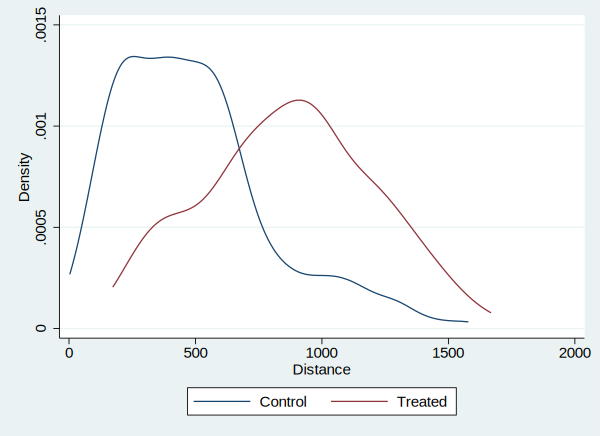

In [9]:
tw kdensity dist_recto if treatment==0, gau || kdensity dist_recto if treatment==1, gau ///
    legend(label(1 "Control") label(2 "Treated") pos(6) rows(1) ) xtitle("Distance") ytitle("Density") 



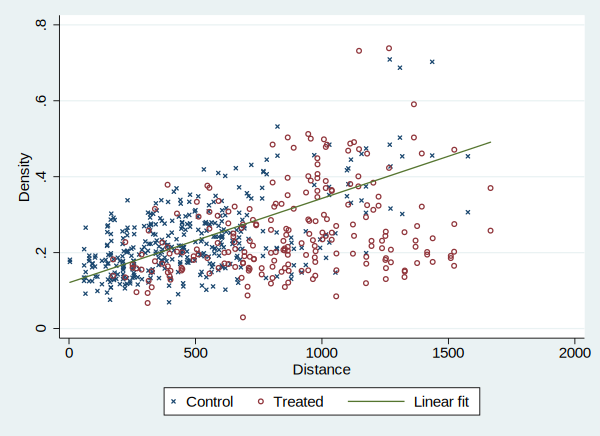

In [10]:
tw scatter abs_diff_ln_price_raw dist_recto if treatment==0, ms(x) || scatter abs_diff_ln_price_raw dist_recto if treatment==1, ms(oh)  || ///
            lfit abs_diff_ln_price_raw dist_recto [aw=factor], ///
            legend(label(1 "Control") label(2 "Treated") label(3 "Linear fit") pos(6) rows(1) ) xtitle("Distance") ytitle("Density") 


# <span style="color:green">Q2 Explain Figure 1. </span>
- Panel 1:
    - What do the round data points represent?
    - What is the red line? What does it measure?
    - What is the vertical line? 
    - Do you see any changes in data before and after the vertical line?

- Panel 2:
    - What are the two lines? What do the `x` data points represent on the blue line?
    - What is the vertical line?
    - What is the vertical line? 
    - Do you see any changes in data before and after the vertical line? What is happening there?


$\textbf{Panel 1:}$

- What do the round data points represent? The round data points represent the monthly mean price of white maize for twenty-five markets over the period 2005:01–2012:06, the price is deflated by CPI, setting the base year as 2005.
- What is the red line? What does it measure? The red line is the lowess trend (Locally Weighted Scatterplot Smoothing). The authors mention that the changes of mean price linked to seasonal dynamics, including periods of drought (e.g., 2005/06; 2008/2009), as well as the increase in global commodity prices in the late 2000s. The lowess trend can help to remove their impact to find a more real trend of the maize price.
- What is the vertical line? The dashed vertical line indicates the opening of the Zambezi bridge.
- Do you see any changes in data before and after the vertical line? After the opening of the Zambezi bridge, the mean price changes within years is smaller and more stable compared with the previous years. Moreover, there is a small downward trending after the vertical line.

  
$\textbf{Panel 2:}$
- What are the two lines? What do the x data points represent on the blue line?  The black line is the mean absolute differences in log. real prices across market pairs over the full period by using the raw data. The blue line is the pre-whitened mean absolute differences in log. real prices. Authors utilize the pre-whitening to move unwanted noise from the series and eliminate common factors that may contaminate unit root tests. X data points represent pre-whitened mean absolute differences in log. real prices for different months.
- What is the vertical line? The vertical line indicates the date of the opening of the Zambezi bridge.
- What is the horizontal line? The horizontal line tells us that the pre-whitened price difference varies between around 0.2 and 0.3. This provides a preliminary indication that price differentials are likely to be stationary.
- Do you see any changes in data before and after the vertical line? What is happening there? I don’t see large changes in data after the vertical line. But it seems that the price difference within a year and within different years is smaller.


## 5.2 Figure 1

### D4. Preparation
1. Clear all existing data and variables from memory.
2. Set the graph scheme to `lean2`.
3. Load the dataset `dyads_worked`.
4. Summarize the `time` variable for observations where `open` equals 1 and store the minimum value in a local macro `open`.

In [11]:
clear all
// set scheme lean2
use "work/dyads_worked"

qui summ time if open == 1 
local open = r(min)
di open






0


### D5. Panel 1 of Figure 1
- Adjust `ln_price` for deflation by dividing the exponential of `ln_price` by `deflator_index` and taking the natural logarithm of the result.

In [12]:
replace ln_price = ln(exp(ln_price) / deflator_index)

(26,700 real changes made)


- Collapse the dataset to calculate the mean of `open`, `ln_price`, and all variables starting with `diff_ln_price`, grouped by `time`, `month`, and `year`.
- you have a collapse command above, can look it up.

In [13]:
collapse (mean) open ln_price *diff_ln_price* , by(time month year)

- Run a regression of `diff_ln_price_raw` on `time` and generate predicted values `fit`.

In [14]:
qui reg diff_ln_price_raw time 
cap drop fit
predict fit




(option xb assumed; fitted values)


- Generate a time series plot of `ln_price` over `time` with a dashed vertical line at the `open` date, and add a lowess trend line.

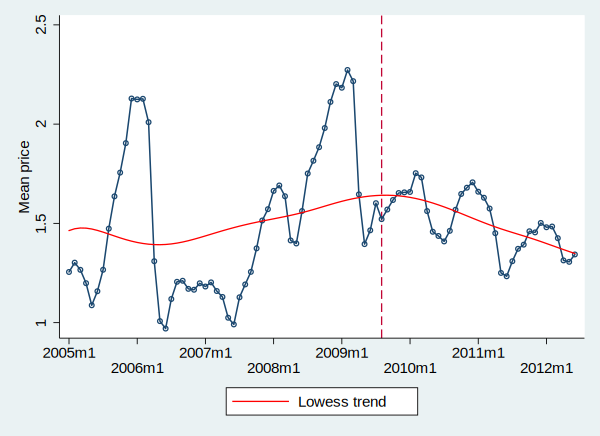

In [15]:
*just choose the correct variables, the options are complete.
tw connect ln_price time, lw(.35) ms(oh) xline(`open', lp(dash))  xtitle("") xlabel(, alt) ylabel(, nogrid) ///
    ytitle("Mean price") name(price, replace) || ///
    lowess ln_price time, legend(label(2 "Lowess trend") pos(6) order(2) ) lp(solid) lcol(red)



### D6 Panel 2 of Figure 1

- Summarize `abs_diff_ln_price_raw` and adjust `abs_diff_ln_price` by adding the mean of `abs_diff_ln_price_raw`.
- Generate a time series plot of `abs_diff_ln_price` and `abs_diff_ln_price_raw` over `time` with a dashed vertical line at the `open` date, and add a horizontal line at the mean of `abs_diff_ln_price_raw`.

In [16]:
qui summ abs_diff_ln_price_raw
qui replace abs_diff_ln_price = abs_diff_ln_price + r(mean)


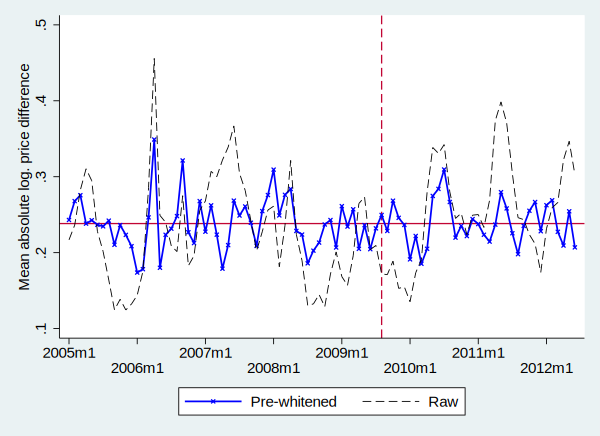

In [17]:
tw connect abs_diff_ln_price abs_diff_ln_price_raw time, ms(x i) mcol(blue) lpat(solid dash) lw(.4 .2) lcol(blue black) ///
    xline(`open', lp(dash)) xtitle("") xlabel(, alt) ytitle("Mean absolute log. price difference") name(dprice, replace) ///
    legend(label(2 "Raw") label(1 "Pre-whitened") pos(6) rows(1)) ylabel(, nogrid) yline(`=r(mean)')


# Part 6: Main results

# <span style="color:green">Q3 Explain in your own words what stationarity means in this context?</span>


In this context, stationarity refers to whether the market price differentials between market dyads exhibit stable long-run equilibrium. The authors are testing whether the time series of absolute log price differentials between dyads contains unit roots before the opening of the bridge. A unit root process in this case would indicate non-stationarity in dyad price differentials, meaning that the long-run relationship between prices in the two markets is not stable and therefore the two markets are not integrated. In this case, the authors strongly reject the null hypothesis that the panels contain unit roots, supporting the alternative hypothesis that the differentials are a stationary process. ✍️ <span style="color:red">This doesn't quite explain what stationarity is in this particular context. For example, how should the data behave to be stationary? You say they must "contain unit root" but what does that mean?</span>


# <span style="color:green">Q4 What stationarity tests do the authors run?</span>
-  What are the differences between them?
- Do they want the data be stationary or not? Why?
    - What if data are stationary?
    - What if they are not?



The stationarity tests that the authors run are panel data unit root tests including Hadri, Harris-Tzavalis, Breitung, Im-Pesaran-Shin (IPS) and Pesaran (CADF). These are based on the equation: 
$$d_{12,t} \leq \tau_{12}(1-\rho) + \rho*(d_{12,t-1} + \eta_{12}$$
-  What are the differences between them?
The Hadri test has stationarity as the null hypothesis, the Harris-Tzavalis tests for a unit root, and focuses on panels with a small T; by assuming there are panels with a small number of time periods, but a large number of cross-sectional units. The Breitung test is suitable for large N and T; it focuses on common components of the panel data. The IPS test allows for heterogeneity in the autoregressive coefficients under the alternative hypothesis, affording flexibility in the panel structure. Finally the Pesaran test deals with the spatial dependence across panels by adding cross-sectional averages to a panel specific Augmented Dickey Fuller test. The motivation for including all of these different tests is a) these tests make different assumptions, and have different applications so consistency between them will make the resulting conclusions more statistically robust. 
- Do they want the data to be stationary or not? Why?
The authors in their results strongly reject the null hypothesis that the panels contain unit roots meaning that the data is stationary. This is consistent with what they wanted; they wanted the data to be stationary because this statistically corroborates long run market integration. There is a constant mean, constant variance, and constant autocorrelation. 
    - What if data are stationary? If the data are stationary, there is no unit root and there is long run market integration.
    - What if they are not? If the data are non-stationary, this means that a unit root is present, this means there is not long run market integration. 


# <span style="color:green">Q5 What is the final functional form that the authors estimate?</span>
- Do they estimate many variants of this form?
- What are the differences between the different variants?
- Use math mode to provide any formulas. 


Do they estimate many variants of this form?What are the differences between the different variants?

Yes, they are. Authors insert equation (5c) into equation (2), adding controls and asserting the equality in absolute terms (as per previous studies) yields an unrestricted dyadic model that exploits both temporal and spatial variation in prices across market pairs. This is how they get the final functional form.

The unrestricted model follows the specification: 
$$
|d_{ij,t}| = \mu_{ij} + (\Delta\gamma)B{ij,t} + \alpha_a(\Delta \cdot Time_{ij})B_{ij,t} + (\Delta\alpha)Time_{b,ij}B_{ij,t} + X'_{ij,t}\phi + \theta_t + \delta_j t + \epsilon_{ij,t}
$$
(1)     They impose the restriction $\Delta \alpha = 0$ to deliver the equivalent of a dyadic DID specification. The model then becomes: 
$$
|d_{ij,t}| = \mu_{ij} + (\Delta\gamma)B{ij,t} + \alpha_a(\Delta \cdot Time_{ij})B_{ij,t} + X'_{ij,t}\phi + \theta_t + \delta_j t + \epsilon_{ij,t}
$$
(2)     They impose the restriction $\Delta \gamma = 0$ to place attention exclusively on the travel time channel but permits the overall treatment effect to depend both on the changes in average travel time and the initial level of the travel time. The model becomes: 
$$
|d_{ij,t}| = \mu_{ij} + \alpha_a(\Delta \cdot Time_{ij})B_{ij,t} + (\Delta\alpha)Time_{b,ij}B_{ij,t} + X'_{ij,t}\phi + \theta_t + \delta_j t + \epsilon_{ij,t}
$$

✍️ <span style="color:red">Your answer could be improved by explicitly discussing all restricted variants (e.g. iv, etc.) </span>



## D7 Preparation to replicate:
1.  Generate and center `dcontrol`: Create a new variable `dcontrol` as the natural logarithm of `time_block`, then center it by subtracting the minimum value when `treat_open` equals 1.
2.  Define control variables as a global: Create a global macro `controls` to include drought and flood variables.
3.  Center `ln_dist_recto`: Calculate the mean value of `ln_dist_recto` and center the variable by subtracting this mean.
4.  Label the variable `treat_open` as `"Bridge ($\Delta\gamma$)"` for clarity (will shuw up in output as "Bridge ($\Delta\gamma$)".
5.  Create interaction terms: Generate two new interaction terms, `iv` as the interaction of `treat_open` and `ln_dist_recto`, and `iv2` as the square of `iv`.


In [18]:
clear all
// set scheme lean2

In [19]:
use "work/dyads_final", clear
tsset




       panel variable:  id_pair (strongly balanced)
        time variable:  time, 2005m1 to 2012m6
                delta:  1 month


In [20]:
gen dcontrol = ln(time_block)
summ dcontrol if treat_open==1
replace dcontrol = dcontrol-r(min)




    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
    dcontrol |      3,920    2.895028    .3151112   2.126495    3.44909

(27,000 real changes made)


In [21]:
global controls drought_one_spe6 drought_both_spe6 flood_one flood_both


In [22]:
summ ln_dist_recto, meanonly
replace ln_dist_recto= ln_dist_recto-r(mean)




(27,000 real changes made)


In [23]:
label var treat_open "Bridge ($\Delta\gamma$)"

In [24]:
gen iv = treat_open*ln_dist_recto
gen iv2 = iv^2

## Main regressions: example of column 1 of Table 2

In this sub-section we will replicate only columns 1 of Table 2. I.e. we will focus on the case where the metric of interest is time and the imposed delay is 7.

### D8 Follow the Step-by-Step directions:


#### Data Setup
1. Clear previous variables: Drop existing `before`, `after`, `diff`, and `this_One` variables if they exist.
2. Generate `after` variable: Create `after` as the natural logarithm of `time_noblock`.
3. Generate `before` variable: Create `before` as the natural logarithm of `time_blocked`.
4. Create `this_One` variable: Combine `before` and `after` weighted by `treat_open`.
5. Adjust `after` and `before`: Replace `after` and `before` values based on `treat_open`.
6. Generate `diff` variable: Create `diff` as the difference between `after` and `before`.

In [25]:
qui{
    estimates drop _all
    cap drop before after diff this_One
    gen after = ln(time_noblock)
    gen before = ln(time_blocked)
    gen this_One = before*( 1 - treat_open ) + treat_open *after
    replace after = treat_open * after
    replace before = treat_open * before
    gen diff = after - before
}

#### Summarize and center `after` and `diff`:
   - Summarize `after` when `treat_open` equals 1.
   - Summarize `diff` and adjust it by subtracting its minimum value when `treat_open` equals 1.

In [26]:
qui summ after if treat_open==1
qui summ diff if after ==r(min)
qui replace diff = (diff - r(min))*treat_open

qui summ after if treat_open==1
qui summ before if after ==r(min)
qui replace before = (before - r(min))*treat_open

# <span style="color:green">Q6 Column 1 of Panel (a) of Table 2 ?</span>
- Explain the specification here. you can use math mode to write a formula
- Interpret the estimated numbers


$|d_ij,t| = μ_ij + (Δγ)B_ij,t + α_a(ΔTime_ij)B_ij,t + (Δα)Time_b,ijB_ij,t + X'_ij,tϕ + θ_t + δ_jt + ε_ij,t$

Interpration:


$\Delta\gamma$ is equal to -0.061. The opening of the bridge led to a 6.1% reduction in the absolute price differences for the closest market pair.

$\alpha_{\alpha} $is equal to 0.066. but it is not statistically significant in this case. Although positive, the lack of significance suggests that while reductions in travel time are associated with reductions in price differentials, this relationship is not strong enough to be statistically confirmed in this specification.

$\Delta\alpha$ is equal to 0.092. It is statistically significant at the level of 10%. This term suggests that longer pre-treatment travel times might slightly increase the effect of the bridge on reducing price differentials.


### D9 Write a stata code that runs the specification you described in the previous question.  It should be something like 
- `full7`: Regress `abs_diff_ln_price` on `treat_open`, `diff`, and `before` with controls, using `reghdfe` and clustering by `FID` and `FID_d`.


In [27]:
qui eststo full7: reghdfe abs_diff_ln_price treat_open diff before $controls, a(id_pair FID_d#c.time year_month) vce(cluster FID FID_d)

# <span style="color:green">Q7 Column 1 of Panel (b) of Table 2 ?</span>
- Explain the specification here. you can use math mode to write a formula
- Interpret the estimated numbers


Specification: Column 1 of Panel (b) in Table 2 presents a restricted specification where αa=0. This specification simplifies the model by removing the interaction term between the change in travel time and the bridge variable.

$$|d_{ij,t}| = \mu_{ij} + \Delta \gamma B_{ij,t} + \Delta \alpha (\text{Time}_{ij}^{\text{before}} \times B_{ij,t}) + X_{ij,t}'\phi + \theta_t + \delta_{jt} + \varepsilon_{ij,t}$$

$\Delta\gamma$ is equal to -0.047. It is not statistically significant at the level of 5%. The opening of the bridge is associated with a 4.7% reduction in the absolute price differences for the most proximate market pair.

$\Delta\alpha$ is equal to 0.108. This indicates that longer pre-treatment travel times are associated with a larger reduction in price differentials due to the bridge opening. Specifically, for each additional unit of pre-treatment travel time, the price differential decreases by 10.8%.


### D10 Write a stata code that runs the specification you described in the previous question.  It should be something like 
- `r17`: Regress `abs_diff_ln_price` on `treat_open` and `before` with controls, using `reghdfe` and clustering by `FID` and `FID_d`.


In [28]:
 qui eststo r17: reghdfe abs_diff_ln_price treat_open before $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)

# <span style="color:green">Q8 Column 1 of Panel (c) of Table 2 ?</span>
- Explain the specification here. you can use math mode to write a formula
- Interpret the estimated numbers


Bridge: the opening of the bridge remains consistently negative for the absolute difference in log. Maize prices. The bridge opening will reduce the price difference a little bit.

Interaction: The interaction here indicates the elasticity of price differentials with respect to travel time changes. It is 0.125, which is highly statistically significant. The decreasing of travel time can significantly reduce the price differentials between market pairs.

RMSE: It is the Root Mean Squared Error. The RMSE for the second restricted model is 0.166, indicating a relatively small average estimation error. 

AIC: The second restricted model has a low AIC, which represents the good fitness of this model. ✍️ <span style="color:red">good fitness:) you meant goodness of fit right?</span>



### D11  Write a stata code that runs the specification you described in the previous question.  It should be something like 
- `r27`: Regress `abs_diff_ln_price` on `treat_open` and `diff` with controls, using `reghdfe` and clustering by `FID` and `FID_d`.


In [29]:
qui eststo r27: reghdfe abs_diff_ln_price treat_open diff $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)

# <span style="color:green">Q9 Column 1 of Panel (a) of Table 3</span>
- Explain the specification here. you can use math mode to write a formula
- Interpret the estimated numbers


Specification: 
$$
|d_{ij,t}| = \mu_{ij} + (\Delta \gamma) B_{ij,t} + \alpha_a (\Delta \text{Time}_{ij} \times B_{ij,t}) + (\Delta \alpha) (\text{Time}_{ij}^{\text{before}} \times B_{ij,t}) + X_{ij,t}'\phi + \theta_t + \delta_{jt} + \varepsilon_{ij,t}
$$

$\Delta\gamma$ is equal to -0.063, which is statistically significant at the 5% level. The opening of the bridge is associated with a 6.3% reduction in the absolute price differences for the most proximate market pair. This result is statistically significant, indicating a substantial impact of the bridge on market integration.

$\alpha_{\alpha}$ is equal to 0.244, which is statistically significant at the 1% level. The decreasing of travel time can significantly reduce the price differentials between market pairs. Each unit reduction in travel time due to the bridge is associated with a 24.4% decrease in the absolute price differential between market pairs.



### D12  Write a stata code that runs the specification you described in the previous question.  It should be something like 
- `iv27`: Regress `abs_diff_ln_price` on controls and `treat_open` (instrumenting `diff` with `iv`), using `ivreghdfe` and clustering by `FID` and `FID_d`.


In [30]:
qui eststo iv27: ivreghdfe abs_diff_ln_price $controls treat_open (diff = iv), a(id_pair FID_d#c.time year_month ) cluster(FID FID_d) partial($controls)

# <span style="color:green">Q10 Column 1 of Panel (b) of Table 3</span>
- Explain the specification here. you can use math mode to write a formula
- Interpret the estimated numbers


Model specification: 
$$
d_{ij,t} = \mu_{ij} + \rho_0 d_{ij,t-1} + \Delta\gamma + \alpha_a (\Delta \cdot Time_{ij}) \times \beta_{ij,t} + d_{ij,t-1} \times \rho_1 + \rho_2 (\Delta \cdot Time_{ij}) \times \beta_{ij,t} + X'_{ij,t} \phi + \theta_t + \delta_j + \epsilon_{ij,t}
$$

The motivation for including the autoregressive component accounts for the gradual adjustment of prices to shocks that occur in a single market. Under this specification, the authors can identify not just the size of the price wedge, but also the speed of price convergence and how these are impacted by the construction of the bridge. 

Bridge: The opening of the bridge remains consistently negative for the absolute difference in log. Maize prices. The bridge opening will reduce the price difference by 1.1%. But the result is not statistically significant.

Interaction: The interaction here indicates the elasticity of price differentials with respect to travel time changes. It is a 5.6% increase, which is statistically significant. The decreasing of travel time can significantly reduce the price differentials between market pairs.

Lagged price diff: 50.4% of the previous price difference have a positive impact on current price difference, and this result is highly significant.

Lag.×Bridge: it tells the interaction effect of the lagged price difference with the bridge opening on the current price difference, which is a 4.3% decrease, though it is not statistically significant.

Lag.×ΔTime×Bridge: it tells the interaction effect of the lagged price difference, the change of travel time, and the bridge opening on the current price difference, which is a 21% increase, though it is not statistically significant.

Obs. (Observations): there are 26,700 observations for this model.

RMSE (Root Mean Squared Error): the average estimation error is relatively small.

✍️ <span style="color:red">Use markdown: Lag.×ΔTime×Bridge should be $\text{Lag.}\times\Delta\text{Time}\times\text{Bridge}$, and so on </span>



$$
d_{ij,t} = \mu_{ij} + \rho_0 d_{ij,t-1} + \Delta\gamma + \alpha_a (\Delta \cdot Time_{ij}) \times \beta_{ij,t} + d_{ij,t-1} \times \rho_1 + \rho_2 (\Delta \cdot Time_{ij}) \times \beta_{ij,t} + X'_{ij,t} \phi + \theta_t + \delta_j + \epsilon_{ij,t}
$$


### D13  Write a stata code that runs the specification you described in the previous question.  It should be something like 
- `lag27`: Regress `abs_diff_ln_price` on lagged values of `abs_diff_ln_price` interacting with `treat_open`, `diff`, `dcontrol`, `open`, and `treatment`, using `reghdfe` and clustering by `FID` and `FID_d`.


In [31]:
qui eststo lag27: reghdfe abs_diff_ln_price c.l.abs_diff_ln_price##c.(treat_open diff) c.l.abs_diff_ln_price#c.(dcontrol open treatment) $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)

# <span style="color:green">Q11 Column 1 of Panel (c) of Table 3</span>
- Explain the specification here. you can use math mode to write a formula
- Interpret the estimated numbers


Bridge: The opening of the bridge remains consistently negative for the absolute difference in log. Maize prices. The bridge opening will reduce the price difference by 2.4%. But the result is not statistically significant.

Interaction: The interaction here indicates the elasticity of price differentials with respect to travel time changes. It is 9.7%, which is statistically significant. The decreasing of travel time can significantly reduce the price differentials between market pairs.

Lagged price diff: 50.4% of the previous price difference have a positive impact on current price difference, and this result is highly significant.

Lag.×Bridge: it tells the interaction effect of the lagged price difference with the bridge opening on the current price difference, which is not statistically significant.

Lag.×ΔTime×Bridge: it tells the interaction effect of the lagged price difference, the change of travel time, and the bridge opening on the current price difference, which is not statistically significant.

Obs. (Observations): there are 26700 observations for this model.

RMSE (Root Mean Squared Error): the average estimation error is relatively small.


### D14 Write a stata code that runs the specification you described in the previous question.  It should be something like 
- `ivlag27`: Regress `abs_diff_ln_price` on lagged values of `abs_diff_ln_price` interacting with `treat_open`, `diff` (instrumenting `diff` with `iv`), and other controls, using `ivreghdfe` and clustering by `FID` and `FID_d`.

In [32]:
qui eststo ivlag27: ivreghdfe abs_diff_ln_price c.l.abs_diff_ln_price##c.(treat_open) c.l.abs_diff_ln_price#c.(dcontrol open treatment) $controls (diff c.l.abs_diff_ln_price#c.diff = iv c.l.abs_diff_ln_price#c.iv ) , ///
            a(id_pair FID_d#c.time year_month ) cluster(FID FID_d) partial($controls cL.abs_diff_ln_price#c.open cL.abs_diff_ln_price#c.treatment c.l.abs_diff_ln_price#c.dcontrol)


### D15 Label the variables:
- Label `diff` as "$\(\Delta\)Time\(\times\)Bridge(\alpha_a)$".
- Label `before` as "$Time (before)\(\times\)Bridge (\Delta\alpha)$".

In [33]:
qui{
    label var diff "$\(\Delta\)Time\(\times\)Bridge(\alpha_a)$"
    label var before "$Time (before)\(\times\)Bridge (\Delta\alpha)$"
    }

### D16 Prepare for displaying
For each model:
   - If the model is not `full` (i.e. NOT panel (a) of table 2):
     - Export table: Use `esttab` to export the results, applying the `stat` macro, with compression, no gaps, variable labels, and significance stars.
     - Restore model: Restore the model estimates using `est restore`.
     - Check VIF: Calculate the variance inflation factor (VIF) to check for multicollinearity.
   - If the model is `full` (i.e. panel (a) of table 2):
     - Restore model: Restore the model estimates using `est restore`.
     - Run hypothesis tests: Conduct hypothesis tests for `treat_open`, `diff`, and `before` variables, storing the p-values as scalars.
     - Store model: Save the updated model estimates.


In [34]:
qui {
    foreach x in full r1 r2 iv2 lag2 ivlag2{
        if ("`x'" != "full") {
            esttab `x'*, compress nogap label  `stat' star(* 0.1 ** 0.05 *** 0.01) b(%9.3f) se(%9.3f)
            est restore `x'7
            vif, unc
        } 
        else {
            est restore `x'7
            test treat_open
            estadd scalar treat_open = r(p), replace
            test diff
            estadd scalar diff = r(p), replace
            test before
            estadd scalar before = r(p), replace
            test treat_open diff
            estadd scalar treat_open_diff = r(p), replace
            test treat_open before
            estadd scalar treat_open_before = r(p), replace
            test diff before
            estadd scalar diff_before = r(p), replace
            est store `x'7
        }
    }

}


In [35]:
local stat stat(N rmse aic treat_open_diff treat_open_before diff_before treat_open diff before, fmt(%9.0fc %9.3f %9.0fc %9.3f) ///
    label("Obs." "RMSE" "AIC" "\( \Delta\gamma = 0 = \alpha_a \)" "$\Delta\gamma = 0 = \Delta\alpha$" "\( \Delta\alpha = 0 = \alpha_a \)" ///
            "$\Delta\gamma=0$" "\( \alpha_a = 0 \)" "$\Delta\alpha = 0$"))


### D17 Display the panels you built earlier, one at a time

#### **Panel (a) of Table 2**

In [36]:
di "Panel (a) of Table 2"
esttab full7, varwidth(40) compress nogap label `stat' drop($controls _cons) star(* .1 ** .05 *** .01) b(%9.3f) se(%9.3f) nodepvars nomtitles nonumbers



Panel (a) of Table 2


-----------------------------------------------------
-----------------------------------------------------
Bridge ($\Delta\gamma$)                     -0.061** 
                                           (0.026)   
$\(\Delta\)Time\(\times\)Bridge(\alpha_a     0.066   
                                           (0.080)   
(before)\(\times\)Bridge (\Delta\alpha)      0.092*  
                                           (0.049)   
-----------------------------------------------------
Obs.                                        27,000   
RMSE                                         0.166   
AIC                                        -20,794   
\( \Delta\gamma = 0 = \alpha_a \)            0.087   
$\Delta\gamma = 0 = \Delta\alpha$            0.056   
\( \Delta\alpha = 0 = \alpha_a \)            0.003   
$\Delta\gamma=0$                             0.032   
\( \alpha_a = 0 \)                           0.418   
$\Delta\alpha = 0$                           0.075   
----

#### **Panel (b) of Table 2**

In [37]:
di "Panel (b) of Table 2"
esttab r17, varwidth(40) compress nogap label `stat' drop($controls _cons) star(* .1 ** .05 *** .01) b(%9.3f) se(%9.3f) nodepvars nomtitles nonumbers



Panel (b) of Table 2


-----------------------------------------------------
-----------------------------------------------------
Bridge ($\Delta\gamma$)                     -0.047   
                                           (0.032)   
(before)\(\times\)Bridge (\Delta\alpha)      0.108** 
                                           (0.039)   
-----------------------------------------------------
Obs.                                        27,000   
RMSE                                         0.166   
AIC                                        -20,786   
\( \Delta\gamma = 0 = \alpha_a \)                    
$\Delta\gamma = 0 = \Delta\alpha$                    
\( \Delta\alpha = 0 = \alpha_a \)                    
$\Delta\gamma=0$                                     
\( \alpha_a = 0 \)                                   
$\Delta\alpha = 0$                                   
-----------------------------------------------------
Standard errors in parentheses
* p<.1, ** p<.05, *** p<.01

#### **Panel (c) of Table 2**

In [38]:
di "Panel (c) of Table 2"
esttab r27, varwidth(40) compress nogap label `stat' drop($controls _cons) star(* .1 ** .05 *** .01) b(%9.3f) se(%9.3f) nodepvars nomtitles nonumbers



Panel (c) of Table 2


-----------------------------------------------------
-----------------------------------------------------
Bridge ($\Delta\gamma$)                     -0.019   
                                           (0.030)   
$\(\Delta\)Time\(\times\)Bridge(\alpha_a     0.125** 
                                           (0.060)   
-----------------------------------------------------
Obs.                                        27,000   
RMSE                                         0.166   
AIC                                        -20,749   
\( \Delta\gamma = 0 = \alpha_a \)                    
$\Delta\gamma = 0 = \Delta\alpha$                    
\( \Delta\alpha = 0 = \alpha_a \)                    
$\Delta\gamma=0$                                     
\( \alpha_a = 0 \)                                   
$\Delta\alpha = 0$                                   
-----------------------------------------------------
Standard errors in parentheses
* p<.1, ** p<.05, *** p<.01

#### **Panel (a) of Table 3**

In [39]:
di "Panel (a) of Table 3"
esttab iv27, varwidth(40) compress nogap label `stat' star(* .1 ** .05 *** .01) b(%9.3f) se(%9.3f) nodepvars nomtitles nonumbers



Panel (a) of Table 3


-----------------------------------------------------
-----------------------------------------------------
$\(\Delta\)Time\(\times\)Bridge(\alpha_a     0.244***
                                           (0.078)   
Bridge ($\Delta\gamma$)                     -0.063** 
                                           (0.030)   
-----------------------------------------------------
Obs.                                        27,000   
RMSE                                         0.165   
AIC                                        -20,721   
\( \Delta\gamma = 0 = \alpha_a \)                    
$\Delta\gamma = 0 = \Delta\alpha$                    
\( \Delta\alpha = 0 = \alpha_a \)                    
$\Delta\gamma=0$                                     
\( \alpha_a = 0 \)                                   
$\Delta\alpha = 0$                                   
-----------------------------------------------------
Standard errors in parentheses
* p<.1, ** p<.05, *** p<.01

#### **Panel (b) of Table 3**

In [40]:
di "Panel (b) of Table 3"
esttab lag27, varwidth(40) compress nogap label `stat' drop($controls _cons) star(* .1 ** .05 *** .01) b(%9.3f) se(%9.3f) nodepvars nomtitles nonumbers



Panel (b) of Table 3


-----------------------------------------------------
-----------------------------------------------------
L.abs_diff_ln_price                          0.504***
                                           (0.024)   
Bridge ($\Delta\gamma$)                     -0.011   
                                           (0.015)   
$\(\Delta\)Time\(\times\)Bridge(\alpha_a     0.056*  
                                           (0.030)   
L.abs_diff_ln_price # Bridge ($\Delta\ga    -0.043   
                                           (0.069)   
L.abs_diff_ln_price # $\(\Delta\)Time\(\     0.210*  
                                           (0.118)   
L.abs_diff_ln_price # dcontrol               0.082***
                                           (0.017)   
L.abs_diff_ln_price # Bridge open            0.051   
                                           (0.034)   
L.abs_diff_ln_price # Treated               -0.070** 
                                           (0.025)   
----

#### **Panel (c) of Table 3**

In [41]:
di "Panel (c) of Table 3"
esttab ivlag27, varwidth(40) compress nogap label `stat' star(* .1 ** .05 *** .01) b(%9.3f) se(%9.3f) nodepvars nomtitles nonumbers



Panel (c) of Table 3


-----------------------------------------------------
-----------------------------------------------------
$\(\Delta\)Time\(\times\)Bridge(\alpha_a     0.097** 
                                           (0.042)   
L.abs_diff_ln_price # $\(\Delta\)Time\(\     0.049   
                                           (0.123)   
L.abs_diff_ln_price                          0.504***
                                           (0.024)   
Bridge ($\Delta\gamma$)                     -0.024   
                                           (0.016)   
L.abs_diff_ln_price # Bridge ($\Delta\ga     0.016   
                                           (0.064)   
-----------------------------------------------------
Obs.                                        26,700   
RMSE                                         0.140   
AIC                                        -29,375   
\( \Delta\gamma = 0 = \alpha_a \)                    
$\Delta\gamma = 0 = \Delta\alpha$                    
\( \

### Take home assignment
Below is the loop that replicates all results of tables 2 and 3. It does contain many unnecessary steps, and everything is done in a loop. Try to replicate the 2nd columns of Tables 2 and 3. You can use our work above and the authors' code. 

```
******* regressions using changes in optimal routes

clear all
set more off
set scheme lean2

use "work/dyads_final", clear
tsset

gen dcontrol = ln(time_block)
summ dcontrol if treat_open==1
replace dcontrol = dcontrol-r(min)

******* Set-up

global controls drought_one_spe6 drought_both_spe6 flood_one flood_both

summ ln_dist_recto, meanonly
replace ln_dist_recto= ln_dist_recto-r(mean)

label var treat_open "Bridge ($\Delta\gamma$)"		

gen iv = treat_open*ln_dist_recto
gen iv2 = iv^2

local tex booktabs fragment nodepvars nomtitles nonumbers replace substitute(_ _) 

******* LOOP

foreach metric in time dist {

    quie forvalues y = 7(-1)2 {

        capture drop before after diff this_One

        noi dis as yellow _n "Metric = `metric', assumed delay = `y'" _n 

        gen after = ln(`metric'_noblock)

        if `y' == 7 gen before = ln(`metric'_blocked) /* infinite blockage */
        else {
            gegen junk = min(ln_`metric'_ch`y'), by(id_pair year) /* zero or negative */
            gen before = after - junk
            drop junk
        }

        gen this_One = before*( 1 - treat_open ) + treat_open *after

        replace after = treat_open * after
        replace before = treat_open * before

        gen diff = after - before
        if `y' != 7 assert round(abs(diff - ln_`metric'_ch`y'),.00001) == 0

        /* uncentered */

*			noi correl diff before if treat_open==1

        eststo r3`y': reghdfe abs_diff_ln_price diff before $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)

        eststo r4`y': reghdfe abs_diff_ln_price diff $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)

        eststo r5`y': reghdfe abs_diff_ln_price before $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)

*			reghdfe abs_diff_ln_price treat_open diff $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)
*			noi nlcom _b[treat_open]/_b[diff]

        eststo r6`y': reghdfe abs_diff_ln_price treat_open $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)

        /* centered */

        summ after if treat_open==1
        noi summ diff if after ==r(min)
        replace diff = (diff - r(min))*treat_open			

        summ after if treat_open==1
        summ before if after ==r(min)
        replace before = (before - r(min))*treat_open		

        eststo full`y': reghdfe abs_diff_ln_price treat_open diff before $controls , a(id_pair FID_d#c.time year_month) vce(cluster FID FID_d)

        eststo r1`y': reghdfe abs_diff_ln_price treat_open before $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)

        eststo r2`y': reghdfe abs_diff_ln_price treat_open diff $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)

        eststo iv2`y': ivreghdfe abs_diff_ln_price $controls treat_open (diff = iv), a(id_pair FID_d#c.time year_month ) cluster(FID FID_d) partial($controls)

        eststo lag2`y': reghdfe abs_diff_ln_price c.l.abs_diff_ln_price##c.(treat_open diff) c.l.abs_diff_ln_price#c.(dcontrol open treatment) $controls , a(id_pair FID_d#c.time year_month ) vce(cluster FID FID_d)

        eststo ivlag2`y': ivreghdfe abs_diff_ln_price c.l.abs_diff_ln_price##c.(treat_open) c.l.abs_diff_ln_price#c.(dcontrol open treatment) $controls (diff c.l.abs_diff_ln_price#c.diff = iv c.l.abs_diff_ln_price#c.iv ) , ///
            a(id_pair FID_d#c.time year_month ) cluster(FID FID_d) partial($controls cL.abs_diff_ln_price#c.open cL.abs_diff_ln_price#c.treatment c.l.abs_diff_ln_price#c.dcontrol)

    }

    /* report */

    if "`metric'" == "time" {
        label var diff "\(\Delta\)Time\(\times\)Bridge ($\alpha_a$)"
        label var before "Time (before)\(\times\)Bridge ($\Delta\alpha$)"
    }
    else {
        label var diff "\(\Delta\)Dist.\(\times\)Bridge ($\alpha_a$)"
        label var before "Dist. (before)\(\times\)Bridge ($\Delta\alpha$)"		
    }

    foreach x in full r1 r2 r3 r4 r5 r6 {

        if "`x'"!="full" local stat stat(rmse aic, fmt(%9.3f %9.0fc) label("RMSE" "AIC"))
        else {
            quie forvalues y = 7(-1)2 {

                est restore full`y'

                test treat_open
                estadd scalar treat_open = r(p), replace

                test diff
                estadd scalar diff = r(p), replace					

                test before
                estadd scalar before = r(p), replace					

                test treat_open diff
                estadd scalar treat_open_diff = r(p), replace					

                test treat_open before
                estadd scalar treat_open_before = r(p), replace					

                test diff before
                estadd scalar diff_before = r(p), replace					

                est store `x'`y'
            }

            local stat stat(N rmse aic treat_open_diff treat_open_before diff_before treat_open diff before , fmt(%9.0fc %9.3f %9.0fc %9.3f) ///
                label("Obs." "RMSE" "AIC" "\midrule \( \Delta\gamma = 0 = \alpha_a \)" "$\Delta\gamma = 0 = \Delta\alpha$" "\( \Delta\alpha = 0 = \alpha_a \)" ///
                        "$\Delta\gamma=0$" "\( \alpha_a = 0 \)" "$\Delta\alpha = 0$" ))
        }

        esttab `x'*, compress nogap label drop($controls _cons) `stat' star(* .1 ** .05 *** .01) b(%9.3f) se(%9.3f)

        esttab `x'* using "out/`metric'_`x'_regs.tex", compress nogap label drop($controls _cons) `stat' `tex' b(%9.3f) se(%9.3f) star(* .1 ** .05 *** .01)

        est restore `x'3
        vif, unc
    }

    local stat stat(N rmse, fmt(%9.0fc %9.3f) label("Obs." "RMSE"))

    if "`metric'" == "time" {
        local rename coeflabel(L.abs_diff_ln_price "Lagged price diff." ///
                              cL.abs_diff_ln_price#c.diff "Lag. \(\times \Delta\)Time $\times$ Bridge" ///
                              cL.abs_diff_ln_price#c.treat_open "Lag. $\times$ Bridge")
    }
    else {
        local rename coeflabel(L.abs_diff_ln_price "Lagged price diff." ///
                              cL.abs_diff_ln_price#c.diff "Lag. \(\times \Delta\)Dist. $\times$ Bridge" ///
                              cL.abs_diff_ln_price#c.treat_open "Lag. $\times$ Bridge")

    }

    foreach x in iv2 lag2 ivlag2 {

        if "`x'"=="iv2" {
            local add
            local order
        }
        else {
            local add `rename'
            local order L.abs_diff_ln_price cL.abs_diff_ln_price#c.treat_open cL.abs_diff_ln_price#c.diff
        }

        if "`x'"=="lag2" local drop drop($controls _cons cL.abs_diff_ln_price#c.open cL.abs_diff_ln_price#c.treatment *dcontrol) 
        else local drop 

        esttab `x'*, compress nogap label `drop' `stat' `add' star(* .1 ** .05 *** .01) b(%9.3f) se(%9.3f) order(treat_open diff `order')

        esttab `x'* using "out/`metric'_`x'_regs.tex", compress nogap label `drop' `add' `stat' `tex' order(treat_open diff `order') b(%9.3f) se(%9.3f) star(* .1 ** .05 *** .01)

    }

        preserve

            local nn = 3 /* assumed delay time */

            est restore r2`nn'

            gen thisOne = ln_`metric'_ch`nn'_c
            collapse ln_`metric'_ch `metric'_ch`nn' ln_`metric'_ch`nn' thisOne if treatment==1 & open==1, by(id_pair)

            gen b  = .
            gen ub = .
            gen lb = .
            local ci = invnormal(.975)
            quie forvalues y = 1/`=_N' {
                summ thisOne in `y'
                local dis = r(mean)
                lincom treat_open + `dis'*diff 
                replace b = r(estimate) in `y'
                replace ub = b + `ci'*r(se) in `y'
                replace lb = b - `ci'*r(se) in `y'
            }

            count if ub <0
            count if b  <0

            sort ln_`metric'_ch`nn'
            tw rarea ub lb ln_`metric'_ch`nn' , pstyle(ci) yline(0, lcol(red)) color(gs5%10) lw(0) xsize(6) ysize(4) ///
                || connect b ln_`metric'_ch`nn', xlabel(-.5(0.1)0) ms(oh) lcol(black) lw(.4) legend(off) xtitle("Log. change in route characteristic (due to bridge)") ylabel(-.15(.05).1) 
        gr export "out/`metric'_reg.pdf", replace

    restore	

    preserve
        local nn = 3 /* assumed delay time */

        est restore iv2`nn'

        gen thisOne = ln_`metric'_ch`nn'_c
        collapse ln_`metric'_ch `metric'_ch`nn' ln_`metric'_ch`nn' thisOne if treatment==1 & open==1, by(id_pair)

        gen b  = .
        gen ub = .
        gen lb = .
        local ci = invnormal(.975)
        quie forvalues y = 1/`=_N' {
            summ thisOne in `y'
            local dis = r(mean)
            lincom treat_open + `dis'*diff
            replace b = r(estimate) in `y'
            replace ub = b + `ci'*r(se) in `y'
            replace lb = b - `ci'*r(se) in `y'
        }

        count if ub <0
            count if b  <0

        sort ln_`metric'_ch`nn'
        tw rarea ub lb ln_`metric'_ch`nn' , pstyle(ci) yline(0, lcol(red)) color(gs5%10) lw(0) xsize(6) ysize(4) ///
            || connect b ln_`metric'_ch`nn', xlabel(-.5(0.1)0) ms(oh) lcol(black) lw(.4) legend(off) xtitle("Log. change in route characteristic (due to bridge)") ylabel(-.15(.05).1) 
        gr export "out/`metric'_ivreg.pdf", replace

*		list
    restore		


}
```

___

**Max 20 points possible + 1 bonus**
1. Max 3 points for completely running code (no errors). ✍️ + 3
    - Comment
2. Max 1 point for clean code (no useless output). ✍️ + 1
    - This one is 1 or 0. 
    - Comment
3. Max 7 points for coding questions ✍️ +7
    - Comment 
4. Max 7 points for write-up questions +6.5
    - Comment
5. Max 2 points for using markdown efficiently (e.g. math mode when needed, or bullet points, or coloring, etc.) ✍️ +1.8
    - Comment
6. Max 1 point for the bonus question ✍️ +
    - Comment 

**Total: 19.3**